In [1]:
from twitch import TwitchClient
import tweepy
import pandas as pd
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret,twitch_client_id)

client = TwitchClient(client_id=twitch_client_id)
#channel = client.channels.get_by_id(44322889)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
currtime = datetime.datetime.now().strftime('%m/%d/%y')



In [2]:
games = len(client.games.get_top())
top_games = []
popularity = []
viewers = []
channels = []
for i in range(games):
    top_games.append(client.games.get_top()[i]['game']['name'])
    popularity.append(client.games.get_top()[i]['game']['popularity'])
    viewers.append(client.games.get_top()[i]['viewers'])
    channels.append(client.games.get_top()[i]['channels'])



df = pd.DataFrame({
    'Game' : top_games,
    'Popularity' : popularity,
    'Views': viewers,
    'Channels': channels
}
)

datestamp = datetime.datetime.now().strftime('%m_%d_%y')
df.to_csv(f'game_data_{datestamp}.csv')


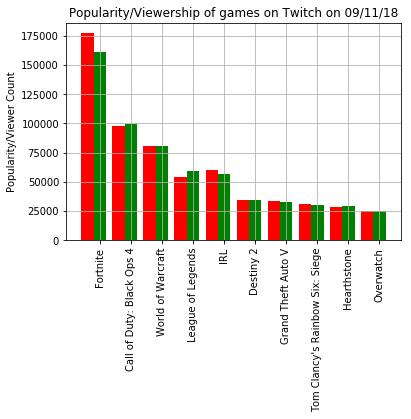

In [3]:
x = np.arange(len(df['Game']))
fig,ax = plt.subplots()

ax.bar(x -0.4 ,df['Popularity'],color='red',align='center',width = 0.4)
ax.bar(x,df['Views'],color='green',align='center',width = 0.4)
ax.set_xticks(x,df['Game'].tolist())
ax.set_ylabel('Popularity/Viewer Count')
ax.grid()
ax.set_title(f'Popularity/Viewership of games on Twitch on {currtime}')
plt.xticks(x,df['Game'].tolist(), rotation=90)
plt.savefig('bar_GamePopularityVsView.png')
plt.show()

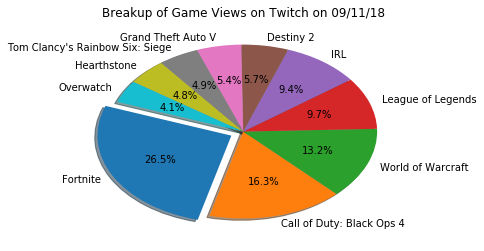

In [4]:
explode=[0.1,0,0,0,0,0,0,0,0,0]
plt.pie(df['Views'],labels=df['Game'].tolist(),shadow=True,startangle=160,explode=explode, autopct='%.1f%%')
plt.title(f'Breakup of Game Views on Twitch on {currtime}')
plt.savefig('pie_GameViewsOnTwitch.png')
plt.show()

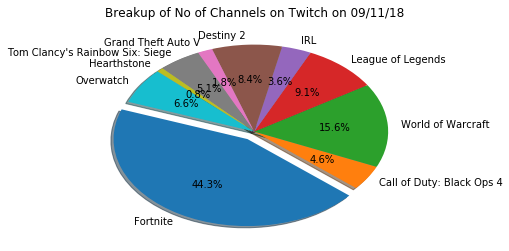

In [5]:
explode=[0.1,0,0,0,0,0,0,0,0,0]
plt.pie(df['Channels'],labels=df['Game'].tolist(),shadow=True,startangle=160,explode=explode, autopct='%.1f%%')
plt.title(f'Breakup of No of Channels on Twitch on {currtime}')
plt.savefig('pie_GameChannelsOnTwitch.png')
plt.show()

In [6]:
#Run twitter analysis

games = df['Game'].tolist()
counter = 0
gamelist=[]
texts=[]
location=[]
sentiments=[]
for game in games:
    oldest_tweet = None
    for x in range(5):
        public_tweets = api.search(game, 
                               count=100, 
                               result_type="recent", 
                               max_id=oldest_tweet)
        for tweet in public_tweets["statuses"]:
            gamelist.append(game)
            texts.append(tweet['text'])
            #location.append(tweet['location'])
            analysis = analyzer.polarity_scores(tweet['text'])
            sentiments.append(analysis['compound'])


            
            oldest_tweet = tweet["id"] - 1
            



In [7]:
df_tweets = pd.DataFrame({
    'Games': gamelist,
    'Tweet Text': texts,
    'Sentiments': sentiments
}
)


,Games,Tweet Text,Sentiments
0,Fortnite,RT @inudayo__wanwan: マイクラでピンクのクマちゃんを作りました～！\n\...,0.0000
1,Fortnite,RT @DemonKrauser: #TESS\n#TeamStreamDream\n#Sm...,0.0000
2,Fortnite,RT @Firstjung1st: ในฐานะคนเล่น pubg และจากการท...,0.0000
3,Fortnite,"RT @incorrectpjm: jimin: ""middle school dances...",0.7506
4,Fortnite,#Fortnite #ps4 #フォートナイト女子 昨日さ、フレンドが急にボクシングさんや...,0.0000
5,Fortnite,RT @Mrbruuuh: Congrats to @realmadriden for wi...,0.7424
6,Fortnite,RT @OpTic_Ghost01: Come watch me suck!!! #PS4l...,-0.5826
7,Fortnite,@h_kanna_channel you bastard stop making werid...,-0.6908
8,Fortnite,@Mr_Bavey @OpTicGaming What? How? Clearly watc...,-0.1926
9,Fortnite,Fortnite Save The World تصبح مجانية للعب خلال ...,0.4939


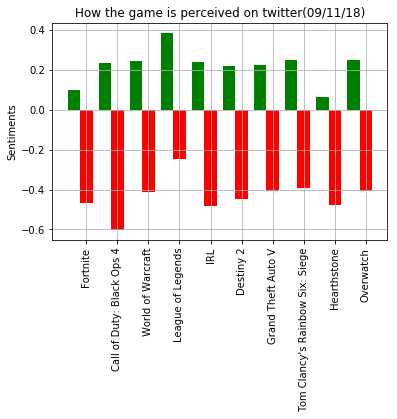

In [10]:

df_positive = df_tweets.loc[df_tweets['Sentiments'] >=0 ].groupby('Games')
df_negative = df_tweets.loc[df_tweets['Sentiments'] <0 ].groupby('Games')

x = np.arange(len(df['Game']))
fig,ax = plt.subplots()

ax.bar(x -0.4 ,df_positive['Sentiments'].mean(),color='green',align='center',width = 0.4)
ax.bar(x,df_negative['Sentiments'].mean(),color='red',align='center',width = 0.4)
ax.set_xticks(x,df['Game'].tolist())
ax.set_ylabel('Sentiments')
ax.grid()
ax.set_title(f'How the game is perceived on twitter({currtime})')
plt.xticks(x,df['Game'].tolist(), rotation=90)
plt.savefig('GameTweetAnalysis.png')
plt.show()

In [11]:
base_url = 'https://contextualwebsearch.com/api/Search/WebSearchAPIWithPagination?q='
search_counts = []
for g in games:
    
    resp = requests.get(f'{base_url}{g}').json()
    search_counts.append(resp['totalCount'])
    
df_searches = pd.DataFrame({
    'Games': games,
    'Search Counts': search_counts
}
)   



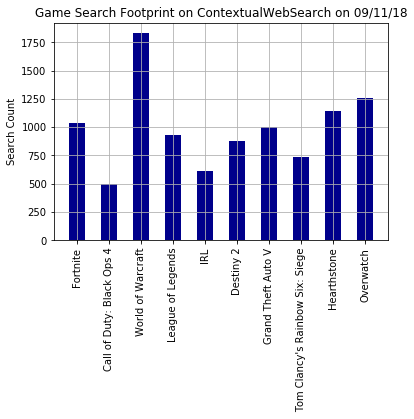

In [12]:
x = np.arange(len(df_searches['Games']))
fig,ax = plt.subplots()

ax.bar(x,df_searches['Search Counts'],color='darkblue',align='center',width = 0.5)
ax.set_xticks(x,df_searches['Games'].tolist())
ax.set_ylabel('Search Count')
ax.grid()
ax.set_title(f'Game Search Footprint on ContextualWebSearch on {currtime}')
plt.xticks(x,df_searches['Games'].tolist(), rotation=90)
plt.savefig('bar_GameSearch.png')
plt.show()

In [13]:
df_hist = pd.read_csv('game_hist.csv')


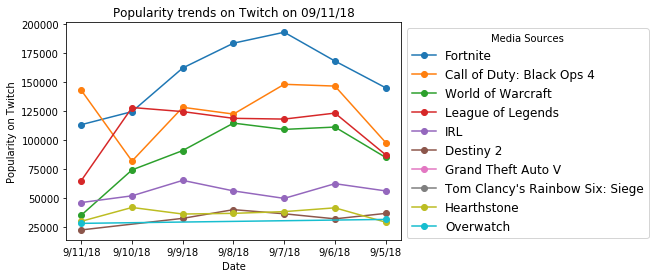

In [14]:
for g in games:

    x_axis = df_hist.loc[df_hist['Game'] == g]['Date']
    y_axis = df_hist.loc[df_hist['Game'] == g]['Popularity']
    plt.xlabel('Date')
    plt.ylabel('Popularity on Twitch')
    plt.title(f'Popularity trends on Twitch on {currtime}')
    plt.plot(x_axis,y_axis, marker='o',label=g)
    plt.legend(bbox_to_anchor=(1, 1), loc=2,fontsize="large", title="Media Sources")


plt.show()    